# 準備

## ライブラリの準備

In [1]:
import sys

if 'google.colab' in sys.modules:
    !pip install japanize-matplotlib -qqq

In [2]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn

## 人工データの生成

今回使用する人工データは、サインカーブに正規分布に従う乱数をノイズとして加えて生成した。
シード値は関数内で固定しているのでいつも同じ乱数を返す。

数式で表すと、 $\mathcal{N}(\sin(x), (0.5)^2)$ である。

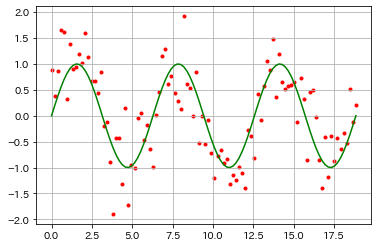

In [3]:
def make_curve(n=100, std=0.5, return_true=False):
    np.random.seed(0)
    x = np.linspace(0, 6*np.pi, n).reshape(-1, 1)
    true = np.sin(x)
    y = true + np.random.normal(scale=0.5, size=[n, 1])
    if return_true:
        return x, y, true
    return x, y

x, y, true = make_curve(return_true=True)
plt.plot(x, true, color="g")
plt.scatter(x, y, marker=".", color="r")
plt.grid(True)

↑真のモデル（緑)と人工データ（赤）の図。

$0 < x < 2.5$ らへんでは、赤点が緑線の上に分布しがちだったり、 $(x, y) = (8, 2)$ らへんに外れ値があったりする。
このようなノイズの影響を受けたデータに対してどのように反応するのかをみると面白い。

## 共通の処理を関数化

In [4]:
def show(x, y, model, pred):
    fig, (l, r) = plt.subplots(1, 2, figsize=[15, 4])
    l.scatter(x, y, marker=".", color="r")
    l.plot(x, model.predict(x))
    r.scatter(x, y, marker=".", color="r")
    r.plot(x, pred, color="k")
    return l, r

In [5]:
from matplotlib import cm


def show_ensemble(model, cmap=cm.jet, alpha=0.3):
    fig, (l, r) = plt.subplots(1, 2, figsize=[15, 4])
    l.scatter(x, y, marker=".", color="r")
    r.scatter(x, y, marker=".", color="r")
    
    estimators = np.array(model.estimators_).ravel()
    for i, (est, s_pred) in enumerate(zip(estimators, model.staged_predict(x))):
        c = cmap(i/model.n_estimators)
        l.step(x, est.predict(x), alpha=alpha, where="mid", color=c)
        r.step(x, pred, alpha=alpha, where="mid", color=c)

    l.set(title="個々の弱学習木")
    r.set(title="更新中の強学習木")
    return l, r

# 単純な決定木

## 理論編

決定木がやっていることは下のようなただの条件分岐。

```python
# 条件分岐
if 緯度が高い:
    return 寒い
else:
    if 標高が高い:
        return 寒い
    else:
        ...
```

でも、条件分岐をするときに必要な要素は、
- 何を基準に分岐するか
- 何回分岐するか

など色々あるため、意外と奥が深い。
今までのモデルの学習は、モデルの予測と真の値との間の誤差を減らすことを目的としていたが、決定木はどれだけ上手くデータを分岐できているかを表す "不純度" というものを減らすことを目的としているため、かなり根本的にやってくことが異なっている。

ニューラルネットワークと同じく、学習データの分布などに依存しないため使いやすく、今一番人気かもしれない。
また、モデルの中身がとても単純なため数学に精通していない人でもモデルを解釈できるというビジネス的長所がある。

（気づかれているかもしれないが後半に行くにつれて理論編が雑になっている。）

## 実装編

決定木の定義に倣って、`plt.plot`ではなく`plt.step`を使っている。（通っている大学の数学科の先生のコードを真似た。）

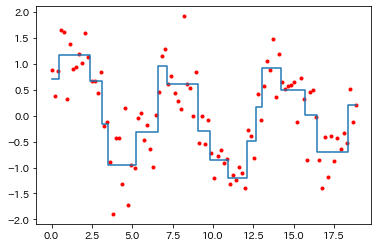

In [6]:
from sklearn.tree import DecisionTreeRegressor

x, y = make_curve()

tree = DecisionTreeRegressor(min_samples_split=11, random_state=0)
tree.fit(x, y.ravel())

plt.step(x, tree.predict(x), where="mid")
plt.scatter(x, y, marker=".", color="r")

## 感想編

「3から5までは-1。5から6までは-0.5。」のように、条件分岐が行われている様子がみてとれる。
これを見てる感じ、階段型のデータには強いが $y=x$ のようにデータが斜めになっているだけでめちゃくちゃ弱くなりそう。

# ランダムフォレスト

## 理論編

その名の通り、ランダムに生成した木をたくさん集めたモデル。
単純な決定木だと回帰線がジグザグになっていたが、たくさん集めて平均化すると少しジグザグがなめらかになる。

## 実装編

ただ結果だけを見るだけではなく、森を成している一つひとつの木も描画してみた。

[Text(0.5, 1.0, '平均した強学習木')]

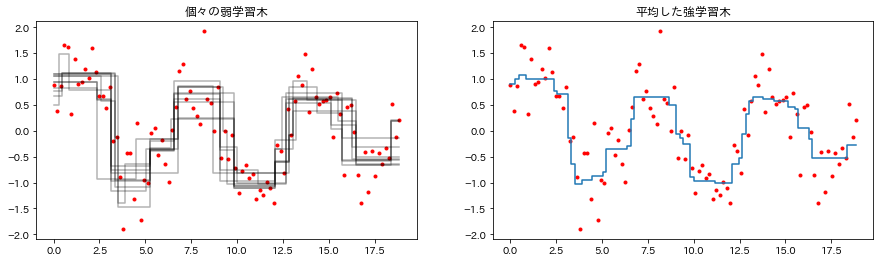

In [7]:
from sklearn.ensemble import RandomForestRegressor

x, y = make_curve()

rf = RandomForestRegressor(min_samples_split=11, n_estimators=10, random_state=0)
rf.fit(x, y.ravel())


fig, (l, r) = plt.subplots(1, 2, figsize=[15, 4])
l.scatter(x, y, marker=".", color="r")
r.scatter(x, y, marker=".", color="r")

estimators = np.array(rf.estimators_).ravel()
for i, est in enumerate(estimators):
    l.step(x, est.predict(x), alpha=0.3, where="mid", color="k")
r.step(x, rf.predict(x), where="mid")

l.set(title="個々の弱学習木")
r.set(title="平均した強学習木")

## 感想編

決定木同士がお互いに補い合って一つになっている感じ。
全ての決定木が本気を出すと全部同じ決定木になってしまうので、ここの決定木に与えるデータはランダムに変えている（ブートストラップサンプリング）。
本気を出させないことで全体としては良くしようという、ランダム性の利用が面白い。

# 勾配ブースティング

## 理論編

まず、1個決定木を作る。次に、前に作った決定木が苦手なところだけを回帰する決定木を作る。それを繰り返すと弱点がないモデルが出来上がる。

XGBoost や LightGBM（Light Gradient Boosting Machine） はこの勾配ブースティングの細かいところを改善したモデルで大枠は同じ。

## 実装編

今回も個々の弱決定木を描画してみた。
ランダムフォレストと異なり弱決定木が作成された順番が大事になるので、古いものから新しいものに向かって青→赤で色を付けている。

[Text(0.5, 1.0, '更新中の強学習木')]

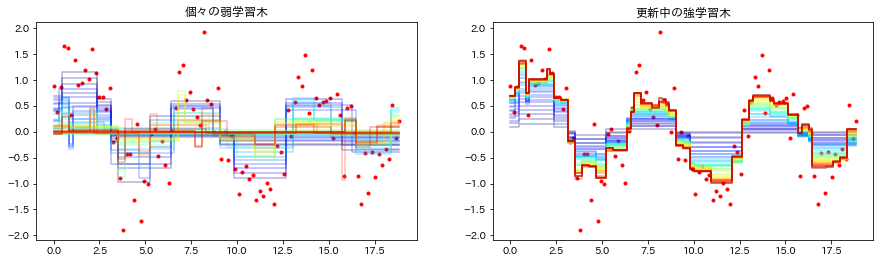

In [8]:
from matplotlib import cm
from sklearn.ensemble import GradientBoostingRegressor

x, y = make_curve()

grad = GradientBoostingRegressor(min_samples_split=11, n_estimators=50, random_state=0)
grad.fit(x, y.ravel())


fig, (l, r) = plt.subplots(1, 2, figsize=[15, 4])
l.scatter(x, y, marker=".", color="r")
r.scatter(x, y, marker=".", color="r")

estimators = np.array(grad.estimators_).ravel()
for i, (est, s_pred) in enumerate(zip(estimators, grad.staged_predict(x))):
    c = cm.jet(i/grad.n_estimators)
    l.step(x, est.predict(x), alpha=0.3, where="mid", color=c)
    r.step(x, s_pred, alpha=0.3, where="mid", color=c)

l.set(title="個々の弱学習木")
r.set(title="更新中の強学習木")

## 感想編

左図の色に着目すると、最初は大まかに概形を決めてから微調整をしているように見える。それを積み重ねていった結果、強決定木はモデルが最適だと思った位置で止まっている。

## LightGBM（番外編）

/Users/yuji_yamamoto/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


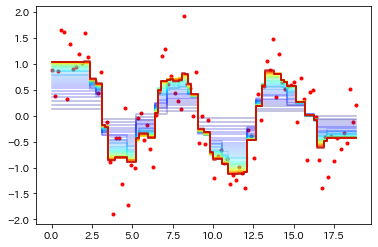

In [9]:
import sklearn.experimental.enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

x, y = make_curve()

hist = HistGradientBoostingRegressor(max_iter=50, min_samples_leaf=10, random_state=0)
hist.fit(x, y.ravel())

for i, pred in enumerate(hist.staged_predict(x)):
    plt.step(x, pred, alpha=0.3, where="mid",
         label=i, color=cm.jet(i/hist.n_iter_)
        )
plt.scatter(x, y, marker=".", color="r")

確かに、モデルの挙動は勾配ブースティングそのもの。
残念ながらこのモデルは他のものと根本的に実装が異なっていたので、個々のモデルが取得できなかった。